In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TUNED | GAUSSIAN PROCESS | LOW MULTICOLLINEARITY

In [40]:
import sys
sys.path.append('../../')
import tokamakTK

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "../../data/"

In [41]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

20.15% of the data decreased alpha_R
79.85% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical and Numerical Data

In [42]:
# Low multicollinearity among numerical features
features =  ['NUSTAR', 'BETASTAR', 'QCYL5', 'HYBRID', 'ENBI', 'POHM', 'TAV', 'RHOSTAR', 'PRAD', 'LHTIME',
            'PNBI', 'DWDIA', 'BT', 'NEL', 'PFLOSS', 'KAREA', 'MEFF', 'WFICFORM', 'IP']

print(len(features))



DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

19


In [43]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [ ]:
# Define random forest classifier with preprocessor as a pipeline


gp = GaussianProcessClassifier(
                                random_state=71,
                                n_jobs=-1
                              )


gp.fit(X_train, y_train)
y_pred= gp.predict_proba(X_test)

In [ ]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Tuned GP', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("All Variables")
plt.legend();

In [ ]:
y_pred_ = gp.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

### FEATURE IMPORTANCE


One way to get the feature importance for a Gaussian Process classifier is to use the **permutation feature importance** method.

For each feature, randomly permute its values in the test data, and compute the recall of the classifier on the permuted data. Repeat this process multiple times to get a more accurate estimate of the feature importance.


In [10]:
n_permutations = 100
feature_importance = np.zeros(X_train.shape[1])

recall = precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])[1][0]

for i in range(X_train.shape[1]):
    recall_diffs = np.zeros(n_permutations)
    for j in range(n_permutations):
        X_test_permuted = X_test.copy()
        X_test_permuted.iloc[:, i] = np.random.permutation(X_test.iloc[:, i])
        y_pred_permuted = gp.predict(X_test_permuted)
        recall_permuted = precision_recall_fscore_support(y_test, y_pred_permuted, labels=[1,0])[1][0]
        recall_diffs[j] = recall_permuted - recall
    feature_importance[i] = np.mean(recall_diffs)

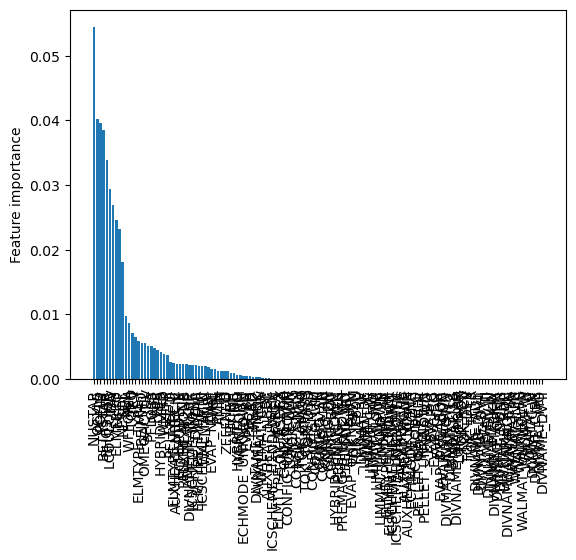

In [11]:
sorted_idx = np.argsort(abs(feature_importance))[::-1]
plt.bar(range(X_train.shape[1]), abs(feature_importance[sorted_idx]))
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.ylabel('Feature importance')
plt.show()

In [12]:
X_train.columns[np.argsort(abs(feature_importance))[::-1][:70]]

Index(['NUSTAR', 'QCYL5', 'POHM', 'BETASTAR', 'RHOSTAR', 'LCOULOMB', 'TAV',
       'ELMFREQ', 'MEFF', 'NESOL', 'NEL', 'WFFORM', 'TORQ', 'TEV',
       'ELMTYPE_TYPE-I', 'BEIMHD', 'OMEGACYCL', 'TIV', 'PFLOSS', 'PNBI', 'EPS',
       'HYBRID_YES', 'WMHD', 'ZEFF', 'PELLET_D', 'ELMTYPE_TYPE-II',
       'AUXHEAT_NBECIC', 'ECHMODE_X', 'PELLET_NONE', 'AUXHEAT_NB',
       'DIVNAME_MARKSR', 'ICSCHEME_NONE', 'DWDIA', 'ELMTYPE_TYPE-III',
       'ICSCHEME_HMIN', 'WALMAT_C', 'ENBI', 'EVAP_NONE', 'VOL', 'PLTH', 'AMIN',
       'IP', 'ZEFFNEO', 'PICRH', 'LHTIME', 'HYBRID_NO', 'WFICFORM',
       'ECHMODE_UNKNOWN', 'EVAP_BE', 'PECRH', 'PRAD', 'DIVNAME_MARK',
       'AUXHEAT_NBIC', 'WALMAT_C-W', 'BT', 'AUXHEAT_NBEC', 'ICSCHEME_H2NDHARM',
       'KAREA', 'ELMTYPE_TYPE-1+2', 'TOK_ASDEX', 'CONFIG_TOP',
       'CONFIG_UNKNOWN', 'TOK_JETILW', 'TOK_AUG', 'CONFIG_SN(L)', 'TOK_AUGW',
       'TOK_CMOD', 'TOK_COMPASS', 'TOK_D3D', 'CONFIG_SN(U)'],
      dtype='object')

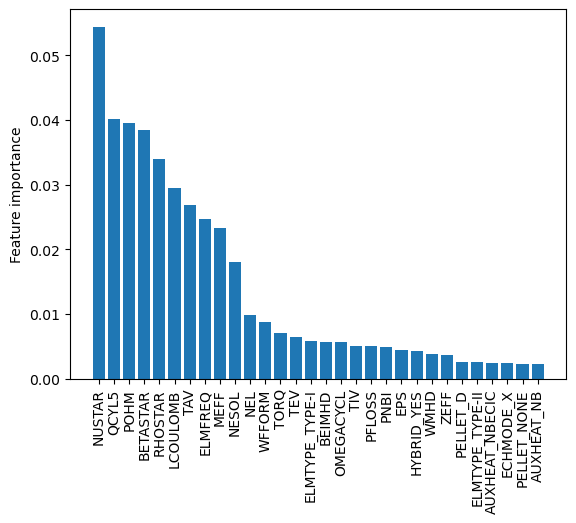

In [20]:
sorted_idx = np.argsort(abs(feature_importance))[::-1][:30]
plt.bar(range(len(sorted_idx)), abs(feature_importance[sorted_idx]))
plt.xticks(range(len(sorted_idx)), X_train.columns[sorted_idx], rotation=90)
plt.ylabel('Feature importance')
plt.show()

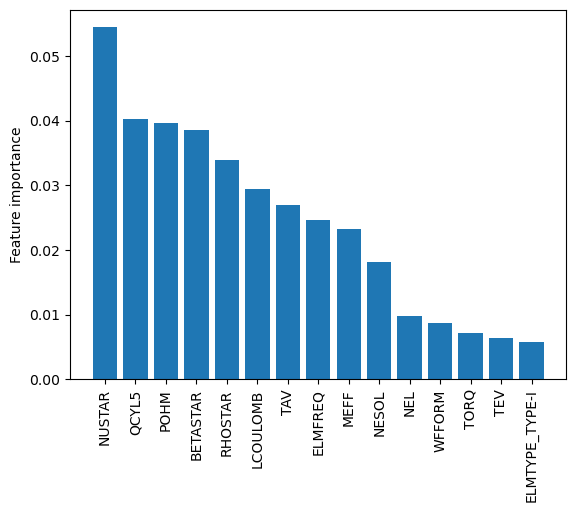

In [18]:
sorted_idx = np.argsort(abs(feature_importance))[::-1][:15]
plt.bar(range(len(sorted_idx)), abs(feature_importance[sorted_idx]))
plt.xticks(range(len(sorted_idx)), X_train.columns[sorted_idx], rotation=90)
plt.ylabel('Feature importance')
plt.show()

In [21]:
X_train.columns[sorted_idx]

Index(['NUSTAR', 'QCYL5', 'POHM', 'BETASTAR', 'RHOSTAR', 'LCOULOMB', 'TAV',
       'ELMFREQ', 'MEFF', 'NESOL', 'NEL', 'WFFORM', 'TORQ', 'TEV',
       'ELMTYPE_TYPE-I', 'BEIMHD', 'OMEGACYCL', 'TIV', 'PFLOSS', 'PNBI', 'EPS',
       'HYBRID_YES', 'WMHD', 'ZEFF', 'PELLET_D', 'ELMTYPE_TYPE-II',
       'AUXHEAT_NBECIC', 'ECHMODE_X', 'PELLET_NONE', 'AUXHEAT_NB'],
      dtype='object')